In [ ]:
#|default_exp off_manifold
# Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
from autometric.utils import plot_3d

# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import autometric
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Off Manifold Pullback
> Learning a non-Euclidean metric that follows density.

What do you do when you have a manifold embedded in a space that leaves lots of gaps, e.g. a tree drawn in $R^2$? Standard pullback metrics won't help us here. Some kind of density regularization is needed. But density regularizations are fickle. Because they depend on weighting the geodesic to follow dense regions, they can warp the geodesics if this parameter is set improperly.

Here we explore another means of constraining geodesics to the manifold: learning a metric that, as soon as one ventures off the manifold, pushes one back on to it. On the manifold, the space is euclidean. Off it, the space becomes increasingly hyperbolic.

# Implementation

We'll implement several versions of this off-manifold pullback, of increasing sophistication. All will use the same API.

## Linear 

To determine if points are off the manifold, we use the density loss from Tong's TrajectoryNet.

$$
L_{\text {density }}\left(x, t_d\right)= \sum_k \max (0, \min_k  \| x-y \|: x \in \mathcal{X}\})-h)
$$

This penalizes $y$ to be within distance $h$ of at least $k$ points. Tong designed this loss to "constrain our ﬂows to the manifold geometry but not to its density". We hope it will do the same for ours.

In [ ]:
#|export
import torch
class OffManifolderLinear():
    """
    Folds points off manifold into higher dimensions using random matrices.
    """
    def __init__(self,
                 X, # n x d points sampled from manifold (in latent space)
                 density_loss_function = None, # function that takes a batch of tensors as input, and outputs a scalar which is 0 on the manifold, and bigger further away.
                 folding_dim = 10,
                 density_k = 5,
                 density_tol = 0.1,
                 density_exponential = 4, 
                 # modify to pass in density_loss
                ):
        self.X = X
        self.device = X.device
        self.dim = X.shape[1]
        self.folding_dim = folding_dim
        self.density_k = density_k
        self.density_tol = density_tol
        self.density_exponential = density_exponential
        self.density_loss_function = density_loss_function
        
        self.preserve_matrix = torch.zeros(self.dim, self.folding_dim, dtype=torch.float).to(self.device)
        for i in range(self.dim):
            self.preserve_matrix[i,i] = 1.0

        self.random_matrix = torch.randn(self.dim, self.folding_dim).to(self.device)
        self.random_matrix[:self.dim, :self.dim] = torch.zeros(self.dim, self.dim).to(self.device)
        # self.random_layer = torch.nn.Linear(self.dim, self.folding_dim)

    def _1density_loss(self, a):
        # 0 for points on manifold within tolerance. Designed for a single point.
        dists = torch.linalg.norm(self.X - a, axis=1)
        print(dists.shape)
        smallest_k_dists, idxs = torch.topk(dists, self.density_k, largest=False) # return k smallest distances
        loss = torch.sum(
            torch.nn.functional.relu( smallest_k_dists - self.density_tol )
        )
        return loss
    def density_loss(self, points):
        if self.density_loss_function is not None:
            return self.density_loss_function(points)
        else:
            return torch.vmap(self._1density_loss)(points)

    def immersion(self, points):
        preserved_subspace = points @ self.preserve_matrix
        random_dirs = points @ self.random_matrix
        # random_dirs = self.random_layer(points)
        weighting_factor = torch.exp(self.density_loss(points)*self.density_exponential) - 1 # starts at 1; gets higher immediately.
        print(f"{preserved_subspace.shape} {random_dirs.shape} {weighting_factor.shape}")
        return preserved_subspace + random_dirs*weighting_factor[:,None]

    def pullback_metric(self, points):
        if not isinstance(points, torch.Tensor): points = torch.tensor(points, dtype=torch.float)
        jac = torch.func.jacrev(self.immersion, argnums = 0) #(points)
        def pullback_per_point(p):
            print(p)
            print(p.shape)
            J = jac(p[None,:])
            J = torch.squeeze(J)
            print("shape J", J.shape)
            return J.T @ J
        return torch.vmap(pullback_per_point)(points)
    

# Tests

We'll perform two validations of this method in this notebook. The first: a simple embedding of a 2D branch into higher dimensions to see if it is working as intended. We'll add noise to the branch and see if these noisy points are strewn into higher dimensions -- ideally with some predictable pattern. Next, we'll compute the pullback metric of this off-manifolder immersion.

## Visual confirmation with the branch

In [ ]:
from autometric.branch_datasets import Branch

In [ ]:
branch = Branch(2, path_length=2)
X_branch = branch.sample(2000)

<matplotlib.collections.PathCollection>

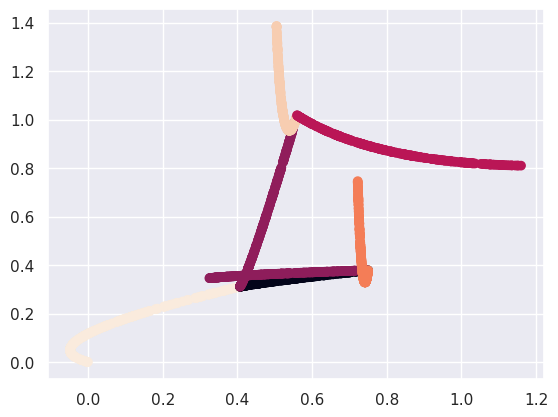

In [ ]:
plt.scatter(X_branch[:,0], X_branch[:,1], c = branch.branch_lengths)

In [ ]:
branch_noise = X_branch + np.random.randn(len(X_branch),2)/15

<matplotlib.collections.PathCollection>

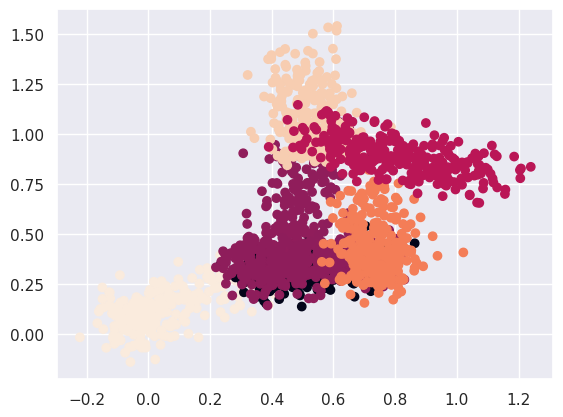

In [ ]:
plt.scatter(branch_noise[:,0], branch_noise[:,1], c = branch.branch_lengths)

Initialize Off-Manifolder

In [ ]:
Offy = OffManifolderLinear(torch.tensor(X_branch), folding_dim=3, density_exponential=5, density_tol=0.05)

In [ ]:
projected_points = Offy.immersion(
    torch.tensor(branch_noise, dtype=torch.float)
).detach().numpy()

torch.Size([1995])
torch.Size([1995, 3]) torch.Size([1995, 3]) torch.Size([1995])


In [ ]:
plot_3d(projected_points, branch.branch_lengths, use_plotly=True)

Off Manifolder with a custom density loss

In [ ]:
def custom_density_loss(query_points, ground_truth_points):
    ground_truth_points = torch.tensor(ground_truth_points).float()
    query_points = torch.tensor(query_points).float()
    D = torch.cdist(query_points, ground_truth_points)
    mean_dist = torch.mean(D, axis=1)
    return mean_dist

In [ ]:
density_function = partial(custom_density_loss, ground_truth_points = X_branch)

The custom density function should take a batch of points as input and return a scalar for each - zero on the manifold, something larger than zero off the manifold.

In [ ]:
density_function(branch_noise[:10])

tensor([0.6486, 0.6286, 0.7272, 0.8386, 0.5063, 0.6334, 0.6944, 0.7813, 0.8704,
        0.7321])

In [ ]:
Offy = OffManifolderLinear(torch.tensor(X_branch), density_loss_function = density_function, folding_dim=3, density_exponential=5, density_tol=0.05)

In [ ]:
projected_points = Offy.immersion(
    torch.tensor(branch_noise, dtype=torch.float)
).detach().numpy()

torch.Size([1995, 3]) torch.Size([1995, 3]) torch.Size([1995])


/tmp/ipykernel_2748978/3757004830.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
plot_3d(projected_points, branch.branch_lengths, use_plotly=True)

## Visualizing the Pullback Metric

In [ ]:
Offy = OffManifolderLinear(torch.tensor(X_branch), folding_dim=10, density_exponential=5, density_tol=0.05)

In [ ]:
projected_points = Offy.immersion(
    torch.tensor(branch_noise, dtype=torch.float)
).detach().numpy()

torch.Size([1995])
torch.Size([1995, 10]) torch.Size([1995, 10]) torch.Size([1995])


In [ ]:
from autometric.metrics import PullbackMetric

In [ ]:
#|export
# construct 2d grid
import numpy as np
def construct_ndgrid(*args):
    # Construct an ndgrid of points
    ndgrid = np.meshgrid(*args, indexing='ij')
    points = np.vstack(list(map(np.ravel, ndgrid))).T
    return points
def construct_ndgrid_from_shape(dim, points_per_dim):
    # Construct an ndgrid of points
    ranges = [np.arange(start=-1,stop=1,step=2/points_per_dim) for _ in range(dim)]
    points = construct_ndgrid(*ranges)
    # move the element closest to the origin to the front
    distances_to_origin = (points**2).sum(-1)
    sorting_idxs = np.argsort(distances_to_origin, )
    points = points[sorting_idxs]
    return points
grid = construct_ndgrid_from_shape(2,100)

In [ ]:
grid = grid*3

In [ ]:
pbms = Offy.pullback_metric(grid)

BatchedTensor(lvl=1, bdim=0, value=
    tensor([[ 2.6645e-15,  2.6645e-15],
            [ 2.6645e-15, -6.0000e-02],
            [-6.0000e-02,  2.6645e-15],
            ...,
            [-3.0000e+00,  2.9400e+00],
            [ 2.9400e+00, -3.0000e+00],
            [-3.0000e+00, -3.0000e+00]])
)
torch.Size([2])
torch.Size([1995])
torch.Size([1, 10]) torch.Size([1, 10]) torch.Size([1])
shape J torch.Size([10, 2])


In [ ]:
pbms.shape

torch.Size([10000, 2, 2])

In [ ]:
entropies = np.array([np.linalg.det(g) for g in pbms])

/home/piriac/Pumberton/Workshop/23-Geometric-AE/autometric/.pixi/envs/default/lib/python3.11/site-packages/numpy/linalg/linalg.py:2181: RuntimeWarning:

overflow encountered in cast

/home/piriac/Pumberton/Workshop/23-Geometric-AE/autometric/.pixi/envs/default/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning:

invalid value encountered in det



In [ ]:
entropies

array([ 1.      , 31.585754, 19.608677, ...,       nan,       nan,
             nan], dtype=float32)

In [ ]:
# trim outlier points
entropies[entropies > 100] = 100
entropies[entropies < -100] = -100

<matplotlib.colorbar.Colorbar>

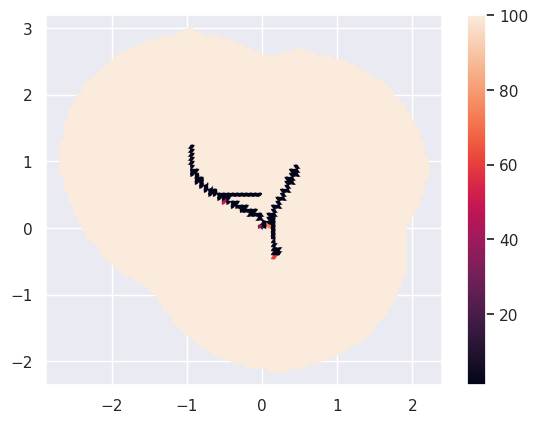

In [ ]:
plt.scatter(grid[:,0], grid[:,1], c=entropies)
plt.colorbar()

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

✨ Pixi task (default): nbdev_export
⠁ activating environment                                                                 